In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

1. Data visualization
2. Data pre-processing
3. Model

In [10]:
train_data_path = ('./feedback-prize-english-language-learning/train.csv')
test_data_path = ('./feedback-prize-english-language-learning/test.csv')

In [11]:
def load_data(path):
    corpus = pd.read_csv(path)
    return corpus

## Data visualization

In [12]:
df = load_data(train_data_path)

In [13]:
df[:4]

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0


In [14]:
df.shape

(3911, 8)

### Data pre processing

In [15]:
def tokenize_data(data):
    tokens = word_tokenize(data)
    return tokens

In [16]:
def lowercase_data(data):
    lowercase = np.char.lower(data)
    return lowercase

In [17]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-.,/:;<=>?@[\]^_`{|}~\n"
    no_punctuation = data
    for i in symbols:
        no_punctuation = np.char.replace(no_punctuation, i, ' ')
        no_punctuation = np.char.replace(no_punctuation, "'", "")        
        
    return no_punctuation

In [18]:
def numbers_to_words(data):
    newData = []
    for i in data:
        if i != str(i):
            num = num2words(i)
            newData.append(num)
        else:
            newData.append(i)
    return newData

In [19]:
def remove_stop_words(data):
    stop_words = set(stopwords.words('english'))
    words = [w for w in data if not w in stop_words]
    return words

In [20]:
def lemmatize_words(data):
    a = []
    lemmatizer = WordNetLemmatizer()
    for i in data:
        lemmatized_word = lemmatizer.lemmatize(i)
        a.append(lemmatized_word)
    return a

In [21]:
def data_cleanning(data):
    df = data
    # Loop through data and clean it.
    for i in data['full_text']:
       
        ndata = tokenize_data(i)
        ndata = remove_punctuation(ndata)
        ndata = lowercase_data(ndata)
        ndata = numbers_to_words(ndata)
        ndata = remove_stop_words(ndata)
        ndata = lemmatize_words(ndata)
        ndata = numbers_to_words(ndata)
        ndata = ' '.join(ndata)
        ndata = remove_punctuation(ndata)
        
        df = df.replace(i, ndata)

    return pd.DataFrame(df)

In [22]:
def split_test_validation(data):    
    train_d, val_d = train_test_split(data, test_size=0.2, random_state=1)
    train_d = pd.DataFrame(train_d)
    val_d = pd.DataFrame(val_d)
    return train_d, val_d

In [23]:
def tf_idf(data):
    
    vectorizer = TfidfVectorizer(max_features=100,
                                 min_df=5,
                                 max_df=0.8,
                                 ngram_range=(1,3))
    vectors = vectorizer.fit_transform(data)
    dense = vectors.todense()
    denselist = dense.tolist()
    feature_names = vectorizer.get_feature_names_out()
    
    all_keywords = []
    for i in denselist:
        x = 0
        keywords = []
        for word in i:
            if word > 0:
                keywords.append(feature_names[x])
            x=x+1
        all_keywords.append(keywords)
    
            
    
    return vectors, denselist, feature_names, all_keywords

In [24]:
def tfidf_pipeline(data):
    dataf = load_data(data)

    train_data, validation_data = split_test_validation(dataf)

    clean_data = data_cleanning(train_data[:30])
    vectors, denselist, feature_names, all_keywords = tf_idf(clean_data['full_text'])
    y = train_data[['vocabulary', 'syntax']]
    
    # Convert vectoried data with keywords into a dataframe
    data=[]
    for i in range(len(all_keywords)):
        data.insert(i, {'words':all_keywords[i],'vectors':denselist[i],})
    dataframe = pd.DataFrame(data)

    return dataframe, y, clean_data, vectors, denselist, feature_names, all_keywords

In [25]:
dataframe, y, clean_data, vectors, denselist, feature_names, all_keywords = tfidf_pipeline(train_data_path)
print('dataframe:\n',dataframe)
print('y:\n',y)
print('clean:\n',clean_data)
print('vectors:\n',vectors)
print('dense:\n',denselist)
print('feature:\n',feature_names)
print('all:\n',all_keywords)

dataframe:
                                                 words  \
0   [friend, good, idea, important, nt, people, sc...   
1   [agree, bad, better, change, example, feel, fi...   
2   [agree, always, bad, best, better, change, cou...   
3   [agree, always, bad, ca, ca nt, could, example...   
4   [better, change, feel, going, good, make, many...   
5   [activity, also, another, benefit, best, bette...   
6   [agree, bad, class, come, day, different, get,...   
7   [able, also, always, best, better, change, cla...   
8   [activity, agree, also, another, benefit, ca, ...   
9   [class, day, every, going, group, learn, lot, ...   
10  [agree, also, always, class, come, day, every,...   
11  [better, could, future, get, go, good, grade, ...   
12  [agree, also, always, another, better, could, ...   
13  [also, day, different, experience, get, good, ...   
14  [able, agree, also, always, bad, best, come, d...   
15  [also, better, class, could, different, exampl...   
16  [bad, better, c

In [26]:
dataframe.to_csv('./tfidfDataInstances.csv')

# Deep Learning: Training with keras

In [177]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

#Bringing the data
train_data_path = ('./feedback-prize-english-language-learning/train.csv')
test_data_path = ('./feedback-prize-english-language-learning/test.csv')

raw_train_ds = load_data(train_data_path)
raw_test_ds = load_data(test_data_path)

def load_data(path):
    corpus = pd.read_csv(path)
    return corpus

This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one example = one string) into either a list of token indices (one example = 1D tensor of integer token indices) or a dense representation (one example = 1D tensor of float values representing data about the example's tokens).

In [178]:
text_dataset = tf.data.Dataset.from_tensor_slices(raw_train_ds['full_text'])
max_features = 30000  # Maximum vocab size.
max_len = 800  # Sequence length to pad the outputs to.

# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

The vocabulary for the layer must be either supplied on construction or learned via adapt(). When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

In [179]:
vectorize_layer.adapt(text_dataset)
# print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [180]:
# The model
model = tf.keras.models.Sequential()
# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing
# vocab indices.
model.add(vectorize_layer)

input_data = [raw_train_ds['full_text']]
test = [raw_test_ds['full_text']]
X_train = model.predict(input_data)
X_test = model.predict(test)
# print(X_test)
Y_train = raw_train_ds[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']]
# print(df['full_text'])
# print(Y_train)

1/1 [==============================] - 0s 13ms/step


In [192]:
embedding_dim = 8

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
#   layers.Dense(512, input_shape=(max_features,)),
#   layers.Activation('relu'),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

epochs = 10
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=epochs)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 8)           240008    
                                                                 
 dropout_60 (Dropout)        (None, None, 8)           0         
                                                                 
 global_average_pooling1d_25  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_61 (Dropout)        (None, 8)                 0         
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 240,017
Trainable params: 240,017
Non-trainable params: 0
_______________________________________________

## Evaluation

In [190]:
loss, accuracy = model.evaluate(X_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1/1 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss:  0.0
Accuracy:  0.0


## Plot the results

dict_keys(['loss', 'accuracy'])


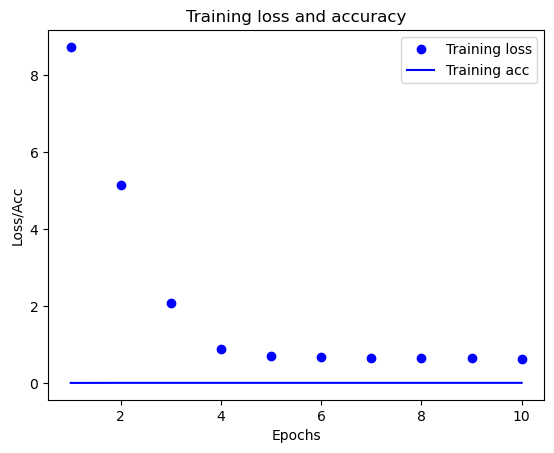

In [191]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

print(history.history.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Acc')
plt.legend()

plt.show()

The desired behavior is for the training loss to decrease, while the accuracy increases. Deep Learning is a suitable approach when we have a large amount of data, since the dataset is not big enough, the model is overfitting.